In [3]:
'''Gathers fundamental information about a stock using the Alpha Vantage API.'''
import os
import requests
import time
import pandas as pd

from ratelimit import limits, sleep_and_retry


API_URL = 'https://www.alphavantage.co/query'
api_key = ''
api_tickers = ['GOOG']

api_functions = ['OVERVIEW',
                 'INCOME_STATEMENT',
                 'BALANCE_SHEET',
                 'CASH_FLOW']


def api_data_function(symbol, function, apikey):
    return {'function': function,
        'symbol': symbol,
        'outputsize': 'full',
        'datatype': 'json',
        'apikey': apikey}


@sleep_and_retry
@limits(calls=5, period=60)
def call_api(url, data):
    return requests.get(url, params=data)


def get_fundamentals_from_api(tickers, functions):
    out_dict = dict()
    for ticker in tickers:
        fund_dict = dict()
        for function in functions:
            response = call_api(API_URL, api_data_function(ticker, function, api_key))
            assert response.ok, f'Error in getting response from server. Ticker {ticker}, function {function}'
            fund_dict[function] = response.json()
        out_dict[ticker] = fund_dict
    return out_dict



# time.sleep(60)
start_time = time.time()

api_results = get_fundamentals_from_api(api_tickers, api_functions)
for result in api_results:
    print(result)
    [print(api_results[result][func]) for func in api_results[result]]

print(f'Total running time: {time.time() - start_time}')

GOOG
{'Symbol': 'GOOG', 'AssetType': 'Common Stock', 'Name': 'Alphabet Inc', 'Description': 'Alphabet Inc. provides online advertising services in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. The company offers performance and brand advertising services. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, such as ads, Android, Chrome, hardware, Google Maps, Google Play, Search, and YouTube, as well as technical infrastructure; and digital content. The Google Cloud segment offers infrastructure and data analytics platforms, collaboration tools, and other services for enterprise customers. The Other Bets segment sells internet and TV services, as well as licensing and research and development services. The company was founded in 1998 and is headquartered in Mountain View, California.', 'Executives': [{'Title': 'CEO & Director', 'Name': 'Mr. Sundar  Picha

In [55]:
api_results['GOOG']['OVERVIEW']

{'Symbol': 'GOOG',
 'AssetType': 'Common Stock',
 'Name': 'Alphabet Inc',
 'Description': 'Alphabet Inc. provides online advertising services in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. The company offers performance and brand advertising services. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, such as ads, Android, Chrome, hardware, Google Maps, Google Play, Search, and YouTube, as well as technical infrastructure; and digital content. The Google Cloud segment offers infrastructure and data analytics platforms, collaboration tools, and other services for enterprise customers. The Other Bets segment sells internet and TV services, as well as licensing and research and development services. The company was founded in 1998 and is headquartered in Mountain View, California.',
 'Executives': [{'Title': 'CEO & Director',
   'Name': 'Mr. Sundar  Pic

In [32]:
def get_annual_data(data, ticker, fin_statement, fin_metric):
    return pd.DataFrame.from_records([(record['fiscalDateEnding'], record[fin_metric]) \
              for record in data[ticker][fin_statement]['annualReports']],\
                              columns=['key', fin_metric]).set_index('key')

<AxesSubplot:title={'center':'grossProfit'}, xlabel='key'>

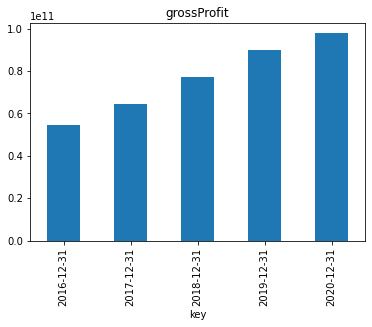

In [38]:
df = get_annual_data(data=api_results,
                    ticker='GOOG',
                    fin_statement='INCOME_STATEMENT',
                    fin_metric='grossProfit')
df['grossProfit'].sort_index().astype('float').plot(kind='bar', title='grossProfit')

In [40]:
api_results['GOOG']['BALANCE_SHEET']['annualReports']

[{'fiscalDateEnding': '2020-12-31',
  'reportedCurrency': 'USD',
  'totalAssets': '319616000000',
  'totalCurrentAssets': '174296000000',
  'cashAndCashEquivalentsAtCarryingValue': '26465000000',
  'cashAndShortTermInvestments': '136694000000',
  'inventory': '728000000',
  'currentNetReceivables': '31384000000',
  'totalNonCurrentAssets': '146720000000',
  'propertyPlantEquipment': '84749000000',
  'accumulatedDepreciationAmortizationPPE': '41713000000',
  'intangibleAssets': '22620000000',
  'intangibleAssetsExcludingGoodwill': '1445000000',
  'goodwill': '21175000000',
  'investments': '138984000000',
  'longTermInvestments': '22103000000',
  'shortTermInvestments': '116087000000',
  'otherCurrentAssets': '5490000000',
  'otherNonCurrrentAssets': '3953000000',
  'totalLiabilities': '97072000000',
  'totalCurrentLiabilities': '56834000000',
  'currentAccountsPayable': '5589000000',
  'deferredRevenue': '3024000000',
  'currentDebt': '1100000000',
  'shortTermDebt': '0',
  'totalNonCu

In [41]:
metric_map = {'INCOME_STATEMENT': ['totalRevenue',
                                   'grossProfit',
                                   'operatingIncome',
                                   'netIncome'],
              'BALANCE_SHEET': ['totalAssets',
                                'totalCurrentAssets',
                                'totalShareholderEquity']}

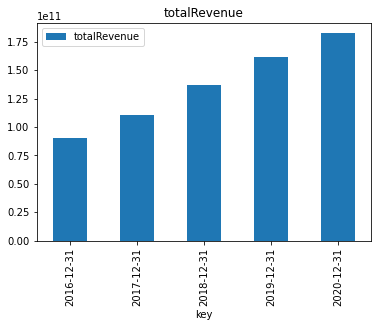

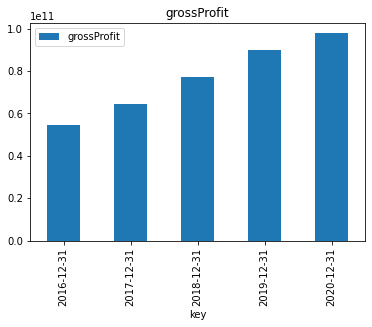

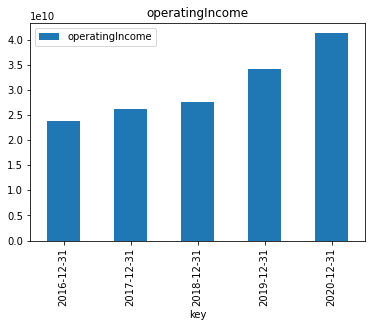

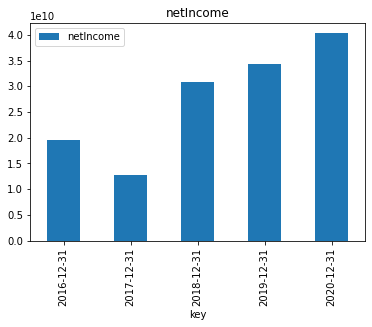

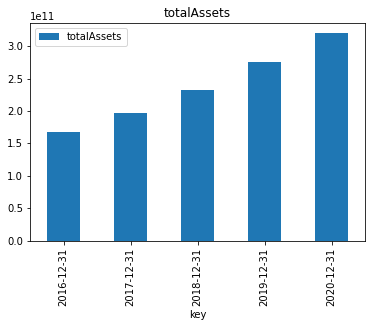

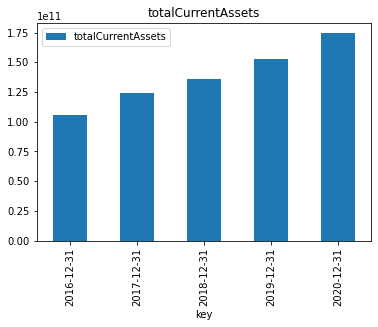

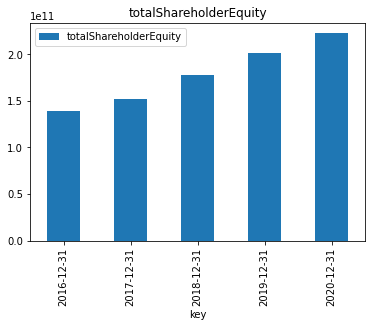

In [49]:
df_annual = pd.DataFrame()
for statement in metric_map:
    for metric in metric_map[statement]:        
        df_tmp = get_annual_data(data=api_results,
                                 ticker='GOOG',
                                 fin_statement=statement,
                                 fin_metric=metric).sort_index().astype('float')
        df_tmp.plot(kind='bar', title=metric)
        if df_annual.empty:
            df_annual = df_tmp
        else:
            df_annual = df_annual.join(df_tmp, how='inner')
df_annual.sort_index(inplace=True)

In [54]:
(df_annual['grossProfit'] / 1000000).astype(int)

key
2016-12-31    54429
2017-12-31    64653
2018-12-31    77270
2019-12-31    89961
2020-12-31    97795
Name: grossProfit, dtype: int32

In [ ]:
# TODO
# Trim YYYY-MM-DD to YYYY
# Values as integers